<a href="https://colab.research.google.com/github/Autobot37/jupyter/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd


import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
vgg = vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [3]:
class VGGFeatureExtractor(nn.Module):
  def __init__(self, vggModel, layerIndices):
    super(VGGFeatureExtractor, self).__init__()
    self.features = vggModel.features

    #layers we need
    self.layerIndices = layerIndices
    self.outputCount =  len(layerIndices)

    for p in self.parameters():
      p.requires_grad = False

  def forward(self,x):


    outputs = list()

    for i, layer in enumerate(self.features.children()):
      x = layer(x)

      if i in self.layerIndices:
        outputs.append(x)


    return outputs







In [4]:
#content img
!curl  --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58417  100 58417    0     0   404k      0 --:--:-- --:--:-- --:--:--  404k


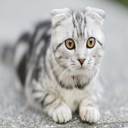

In [5]:
content_image = Image.open('cat.jpeg').resize((128,128))
content_image


In [6]:
#style image
!curl --output style.jpeg "https://images.pexels.com/photos/3992944/pexels-photo-3992944.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  201k  100  201k    0     0  1398k      0 --:--:-- --:--:-- --:--:-- 1388k


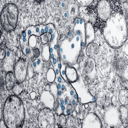

In [7]:
style_image = Image.open('style.jpeg').resize((128,128))
style_image

In [8]:
def pil_to_torch(im):
  return torch.tensor(np.array(im)/255.0,dtype=torch.float).permute(2,0,1).unsqueeze(0)

In [9]:
#extract content features
content_im_tensor = pil_to_torch(content_image)
contentExtractor = VGGFeatureExtractor(vgg, [15,19]) #extracting outputs from 15th and 19th layer and it is totlly experimental
target_content_features = contentExtractor(content_im_tensor)
 

In [10]:
#same for style 
style_im_tensor = pil_to_torch(style_image)
styleExtractor = VGGFeatureExtractor(vgg, [5,9,11,13,15,17,19])
target_style_features = styleExtractor(style_im_tensor)


In [11]:
def content_loss(im, target_content_features):
  im_content_features = contentExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_content_features, target_content_features):
    loss += nn.L1Loss()(im_features, target_features)

  return loss


In [12]:
#style loss is tricky as describe originally via gram matrix .
def gram(x):
	b,c,h,w = x.size();
	x = x.view(b*c, -1);
	return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers
 
def style_loss(im, target_style_features):
  im_style_features = styleExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_style_features, target_style_features):
    im_gram = gram(im_features)
    target_gram = gram(target_features)
    loss += F.mse_loss(im_gram, target_gram);
  return loss/len(im_style_features)





In [13]:
im = pil_to_torch(content_image)
im.requires_grad = True

In [17]:
optimizer = torch.optim.Adam([im], lr=5e-3)


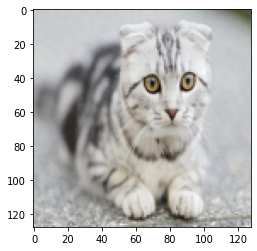

6.6081013679504395


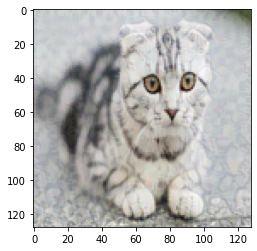

3.623173475265503


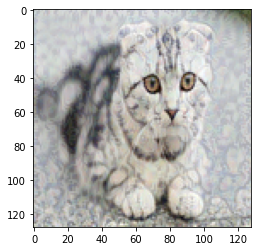

2.5785603523254395


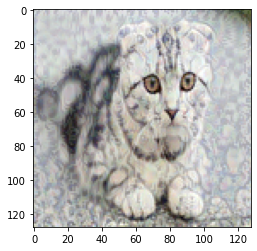

2.1131582260131836


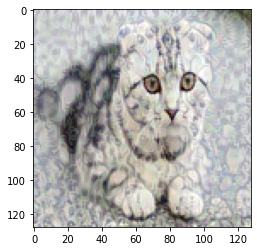

1.8681434392929077


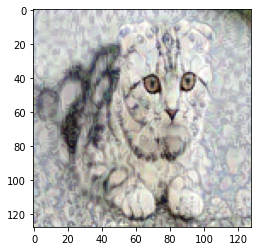

1.721456527709961


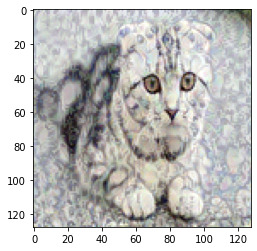

1.6257330179214478


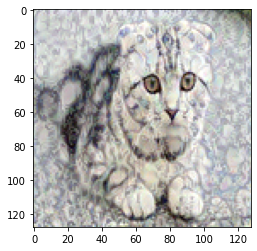

1.5622379779815674


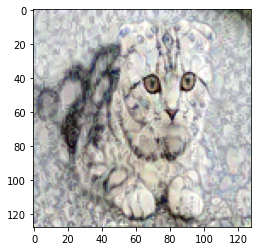

1.5168730020523071


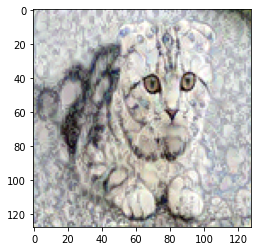

1.4833807945251465


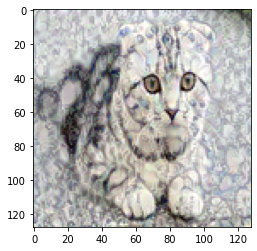

1.457031011581421


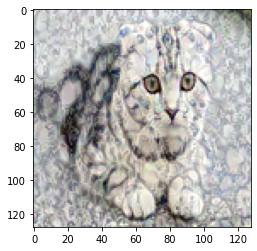

1.4360520839691162


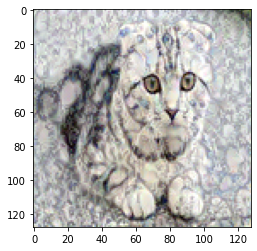

1.418864369392395


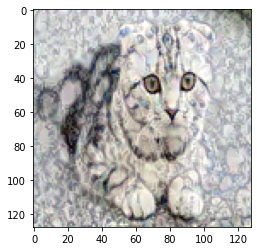

1.4043599367141724


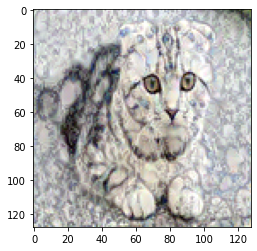

1.3917968273162842


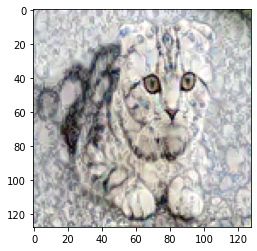

1.3806637525558472


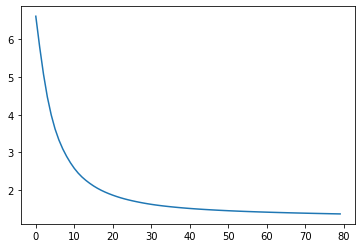

In [18]:
losses = []
for i in range(80):
  optimizer.zero_grad()

  loss = 5 * style_loss(im.clip(0,1), target_style_features)
  loss += content_loss(im.clip(0,1), target_content_features)
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().item())

  if i%5==0:
    plt.imshow(im.clip(0,1).detach().squeeze().permute(1,2,0))
    plt.show()
    print(loss.item())

plt.plot(losses)